In [1]:
# tell ipython that we are running in a notebook. 
%matplotlib notebook     

# import a few key modules, these should be sufficient to complete the assignment
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
from scipy.ndimage import distance_transform_edt
import pickle

# import the provided functions to support point selection in the notebook
import selectpoints

***
# Point Correspondence

The first image in each example provided is the central image.  It's simplest
to construct a mosaic from a central image and a set of peripheral images,
since we then need to find just one homography for each peripheral image. We
should flesh out the code below to allow the user to manually select at least
4 pairs of correpsonding points between each central and peripheral image. 
These points should be located on distinctive locations that we can easily 
identify between the images such as high contrast corners.

The code below which loads in the central image and then loops over the
remaining images and for each image allows you to select four or more points.
Save out the resulting points to a pckl file which you will include as part of 
your upload. We should encapsulate the basic procedure of getting the point 
correpsondences in a function called **get_correspondences** to make it easier 
to run on different sets of images to produce the final result
***

In [2]:
def get_correspondences(imnames,baseim,npoints=4):
    
    """
    The function loads in a set of images which are going to be assembled
    in to a mosaic. It displays the central (base) image along with each
    peripheral image and allows the user to click to to select corresponding
    points between the base image and the peripheral image. It returns the
    images along with the user input. If the original image files were in 
    color the function converts them to grayscale. 
    
    Parameters
    ----------
    imnames : list of str
        Filenames of image files that are going in to the mosaic
    
    baseim : int
        An index which specifies which of the image files is the base image
        
    npoints : int
        How many points are required from the user. Defaults to 4
        
    Returns
    -------
    imgs : list of 2D float arrays
        The arrays for the corresponding images given in imnames. These 
        are gray scale images represented as floats.   
     
    pointmatches : list of SelectPoints objects
        Returns an object whose fields xs and ys contain the point 
        coordinates once the user has clicked  (see selectpoints.py)
        
    """

    nimages = len(imnames)

    # loop over images and load in each one and convert to grayscale
    imgs = list()
    for fname in imnames:  
        print('loading...',fname)
        I = plt.imread(fname)
        
        # convert to float data type if necessary        
        # optional: downsample the image to 1/4 resolution just to make things run quickly
        I = zoom(I,0.25)
        
        # convert from color to grayscale if necessary
        if len(I.shape) == 3:
            if I.shape[2] == 3:
                temp_I = (I[:, :, 0] + I[:, :, 1] + I[:, :, 2])/3
                I = temp_I
    
        # finally, store the array in our list of images
        imgs.append(I)
 
    # loop over each pair of overlapping images and have the user 
    # click to specify corresponding points
    pointmatches = list()
    for i in range(nimages):
        if (i==baseim):
            continue
        
        fig = plt.figure()
    
        # select points in base image
        ax1 = fig.add_subplot(2,1,1)
        ax1.imshow(imgs[baseim],cmap=plt.cm.gray)
        sp1 = selectpoints.select_k_points(ax1,npoints)

        # corresponding points in overlapping image
        ax2 = fig.add_subplot(2,1,2)
        ax2.imshow(imgs[i],cmap=plt.cm.gray)
        sp2 = selectpoints.select_k_points(ax2,npoints)
 
        pointmatches.append((sp1,sp2))

    return imgs,pointmatches

***
# Homography Transformations

For each image, we will need to compute the homography (3x3 transformation matrix) 
using linear least squares. This transformation should map the points in the 
peripheral image that we clicked to their corresponding points in the base 
"central" image. For the central image itself, this transformation would just be 
the identity matrix.

The first function, **compute_homography**
should estimate a transformation matrix H given the pairs of points.  The second function,
**apply_homography** should take as input an array of point coordinates and a 3x3 matrix 
and return the transformed coordinates.

Note that if the matrix <tt>H</tt> maps (x1,y1) to (x2,y2), then the inverse
mapping is given simply by inverting the matrix.  So applying the homography
<tt>inv(H)</tt> will map (x2,y2) back to (x1,y1).

In [6]:
def compute_homography(pts1,pts2):
    """
    Computes the 3x3 transformation matrix (homography) that when applied to pts1 yields pts2
    
    Parameters
    ----------
    pts1 : 2xN array
        2D coordinates of points (to warp)

    pts2 : 2xN array
        target 2D coordinates where points should end up

    Returns
    -------
    numpy.array (dtype=float)
        3x3 array containing the matrix H
        
    """

    # expected dimensions of input
    assert(pts1.shape[0]==2)
    assert(pts2.shape[0]==2)
    assert(pts1.shape[1]>=4)
    assert(pts2.shape[1]>=4)
    
    b = np.reshape(pts2, pts2.shape[0] * pts2.shape[1] ,order = "F")
    A = np.zeros((2 * pts1.shape[1], 8))
    
    for i, r in enumerate(A):
        if i % 2 == 0:
            r[0], r[1], r[2] = pts1[0,int(i/2)], pts1[1,int(i/2)], 1
            r[6] = -(pts2[0,int(i/2)] * pts1[0,int(i/2)])
            r[7] = -(pts2[0,int(i/2)] * pts1[1,int(i/2)])
        else:
            r[3], r[4], r[5] = pts1[0,int(i/2)], pts1[1,int(i/2)], 1
            r[6] = -(pts2[1,int(i/2)] * pts1[0,int(i/2)])
            r[7] = -(pts2[1,int(i/2)] * pts1[1,int(i/2)])
            
    H = np.linalg.lstsq(A, b, rcond = None)[0]
    H = np.append(H, 1)
    H = np.reshape(H, (3, 3))

    # expected dimension of output
    assert (H.shape==(3,3))
    
    return H 

In [7]:
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates
    
    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform
        
    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points
        
    """

    # assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)
    
    s = len(pts[0])
    tpts = np.zeros((2, s)) 
    
    for i in range(s):
        sep_pts = [pts[0,i], pts[1,i], 1]
        result = np.matmul(H, sep_pts)
        tpts[0,i] = result[0] / result[2]
        tpts[1,i] = result[1] / result[2]
    
    # make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])
    
    return tpts

# Warping

Implement a function called **warp_images** which takes the collection of correspondences
and generates warped versions of all the input images to align them with the final mosaic.

1. We will use the central image's coordinate system for the final mosaic.  We
first need to figure out how big the final mosiac will be.  We can accomplish
this by determining where the corners of each source image will be mapped to in
the final mosaic (using your **apply_homography** function) and then use min/max to
determine the left-most, right-most, top-most and bottom-most points across all
of the warped images. After this step we will have determined that all the
warped image pixels from all the images will fall inside some rectangular region *(xmin,ymin)-(xmax,ymax)*.

2. Generate the coordinates of all the pixels for you final mosaic as well as the
coordinates of pixels in each source image (using **np.mgrid** for this). 
To get the warped image coordinates, apply the estimated homography to the source
image pixel coordinates to determine where they will fall in the output mosaic.<p>

3. To produce the warped image, we will use **scipy.interpolate.griddata** to 
perform interpolation of the gray values onto a regular grid. We need to provide **griddata** 
with three pieces of information: the coordinates of the pixels after we have warped 
them with the appropriate homography, the gray value for each of those pixels, and 
the grid of pixel coordinates for our final mosaic. We will call this interpolation 
function for each source image, resulting in a new warped image the size of the final 
mosaic. By default, **griddata** will set the value of any pixels that are 
outside the source image to NaN. The figure at top shows examples of warped images where 
the white pixels correspond to regions outside the source image (i.e. filled with NaNs).<p>

In [9]:
def warp_images(imgs,baseim,srcpts,basepts):
    """
    Warp a collection of images to align them with a central base image using 
    provided point correspondences to estimate the warping.
    
    
    Parameters
    ----------
    imgs : list of 2D numpy.array (dtype=float)
        The arrays containing the input grayscale images  
  
    baseim : int
        The index of the image which is the central base image
        
    srcpts: list of 2D numpy.array, each of size 2xNclicks 
        x,y coordinates of points clicked by the user for each peripheral image

    basepts : list of 2D numpy.array, each of size 2xNclicks
        x,y coordinates of correponding locations in the base image
        
    Returns
    -------
    imgs_warped: list of 2D numpy.array (dtype=float)
        list of the resulting warped images, all of which will have the same shape
        
    """

    # first estimate all the homographies
    homs = list()
    for i in range(len(imgs)):
        if (i == baseim):
            H = np.identity(3)
        else:
            H = compute_homography(srcpts[i - 1], basepts[i - 1]) #compute homography based on clicked points
        homs.append(H)
    
    # compute where the corners of each warped image end up
    # and the upper left and lower-right corners of a rectangle
    # that will enclose all of them
    ul = np.array([0,0])
    lr = np.array([0,0])
    left_most = np.inf
    top_most = np.inf
    right_most = -np.inf
    bottom_most = -np.inf
    
    for i in range(len(imgs)):
        # original coorner coordinates
        cx = np.array([[0, imgs[i].shape[1] - 1, 0, imgs[i].shape[1] - 1], [0, 0, imgs[i].shape[0] - 1, imgs[i].shape[0] - 1]])
        
        # warped coordinates
        cx_warped = apply_homography(homs[i],cx)
         
        lt_x, rt_x, lb_x, rb_x = cx_warped[0][0], cx_warped[0][1], cx_warped[0][2], cx_warped[0][3]
        lt_y, rt_y, lb_y, rb_y = cx_warped[1][0], cx_warped[1][1], cx_warped[1][2], cx_warped[1][3]
        
        if lt_x < left_most:
            left_most = lt_x
        if lb_x < left_most:
            left_most = lb_x
            
        if rt_x > right_most:
            right_most = rt_x
        if rb_x > right_most:
            right_most = rb_x
            
        if lt_y < top_most:
            top_most = lt_y
        if rt_y < top_most:
            top_most = rt_y
        
        if lb_y > bottom_most:
            bottom_most = lb_y
        if rb_y > bottom_most:
            bottom_most = rb_y
            
    ul = [left_most, top_most]
    lr = [right_most, bottom_most]
    
    # round these to integer valued coordinates
    ul = np.floor(ul)
    lr = np.floor(lr)
    print(f"The output image size would be {int(lr[0]-ul[0])}x{int(lr[1]-ul[1])}")

    # generate the coordinates of pixels in the output image that
    # cover the bounding rectangle determined above
    ogrid_y, ogrid_x = np.mgrid[int(ul[1]):int(lr[1]), int(ul[0]):int(lr[0])]
    
    # loop over each input and warp it
    imgs_warped = list()
    for i in range(len(imgs)):
        
        # input pixel grid
        igrid_y, igrid_x = np.mgrid[0:len(imgs[i]), 0:len(imgs[i][0])]
        
        # reshape igrid_y and igrid_x into a 2xN array so we can use
        # our applyHomography function on them.  you can do
        # this with some combination of flatten() and stack()
        igrid_x = igrid_x.flatten()
        igrid_y = igrid_y.flatten()
        incoords = np.stack((igrid_x, igrid_y))
        
        # transform pixel coordinates
        warpedcoords = apply_homography(homs[i],incoords)
        
        # brightness values reshaped as a Nx1 array
        bvalues = imgs[i].flatten()
        wcoords = np.transpose(warpedcoords)
        
        # use griddata to warp 
        img_warped = griddata(wcoords, bvalues,(ogrid_x, ogrid_y))
        imgs_warped.append(img_warped)
    
    return imgs_warped

***

# 4. Blending

Now that we have generated the individual warped images, we need to blend
them together into the final mosaic image.  The simplest approach is to paste 
down the pixels from each warped image in some order into the output image. 
However, we should create a smooth blend between the images in the regions where they 
overlap.

***Approach: Distance transform***: For each mask, use **scipy.ndimage.distance_transform_edt** to 
create an array whose entries are the distance to the edge of the mask. Make the 
alpha for the image proportional to this distance. we will likely want to clip 
the distance at some maximum threshold **t** so that pixels a distance greater 
than **t** from the boundary all get the full weight (rather than only those in the
very center of the image).

Since more than one image can overlap at a given location, the final step we will 
need to carry out is to normalize these alpha maps by the sum 
of the alphas across all images at that location.  In the end, the 
alpha weights should satisfy the following properties:

1. The alpha weight for an image is non-zero only where the binary mask is non-zero. 
2. The alpha weight for an image should decay to zero at the edge of the mask
3. The sum of the alpha weights across the images should be 1 (except for pixels not covered by any of the input images)


In [10]:
def blend_images(imgs_warped):
    """
    Blend together a collection of warped images into a mosaic 
    using alpha masks to smooth transitions between individual photos
    
    
    Parameters
    ----------
    imgs_warped : list of 2D numpy.array (dtype=float)
        The arrays containing the warped grayscale images. Assumed to have a value
        of nan value in locations where the brightness is unknown
          
    Returns
    -------
    mosaic: 2D numpy.array (dtype=float)
        The blended mosaic
        
    alphas: list of 2D numpy.array (dtype=float)
        The alpha masks used for blending together the mosaic
        
    """
    
    # compute a mask for each warped image which is 1.0 were the pixels are valid
    # and 0.0 anywhere there is a NaN
    masks = list()
    for i in range(len(imgs_warped)):
        masks = np.append(masks, np.reshape([0. if np.isnan(p) else 1. for p in imgs_warped[i].flatten()], imgs_warped[i].shape))

    masks = np.reshape(masks, np.array(imgs_warped).shape)
        
    # now compute a alpha map by either blurring the masks to feather the boundaries
    # or using the distance transform clipped to some maximum distance.
    alphas = np.zeros(np.array(imgs_warped).shape)
    
    for i in range(len(imgs_warped)):
        alphas[i] = distance_transform_edt(masks[i])
       
    # need to make sure alphas are zero anywhere the mask is 0, and
    # normalize the alphas so that they sum to 1 anywhere they overlap
    # if a pixel is not covered by any input image, then set the alphas to 0 there
    # so it will appear black in the final result.
    for i in range(alphas[0].shape[0]):
        temp = list()
        
        for j in range(len(alphas)):
            temp.append(alphas[j][i])
    
        s = np.sum(np.reshape([temp], (len(alphas), alphas[0].shape[1])), axis = 0)
        
        for j in range(len(alphas)):
            alphas[j][i] = [p[0]/p[1] if p[1] != 0 else 0 for p in zip(alphas[j][i], s)]
               
    # finally blend together all the sorce images using the alpha weights
    # create an output image of all zeros where we will composite the warped images
    mosaic = np.zeros(imgs_warped[0].shape)

    # deal with the fact that imgs_warped contains NaNs.
    # the output mosaic should not contain any NaNs, just 0s
    # in the places which are not covered by any input image
    for i in range(len(imgs_warped)):
        temp = imgs_warped[i].copy()
        temp[np.where(np.isnan(temp))] = 0
        mosaic = mosaic + alphas[i]*temp
                 
    return mosaic, alphas

# Result 1

loading... atrium/IMG_1347.JPG
loading... atrium/IMG_1348.JPG
loading... atrium/IMG_1349.JPG


<IPython.core.display.Javascript object>


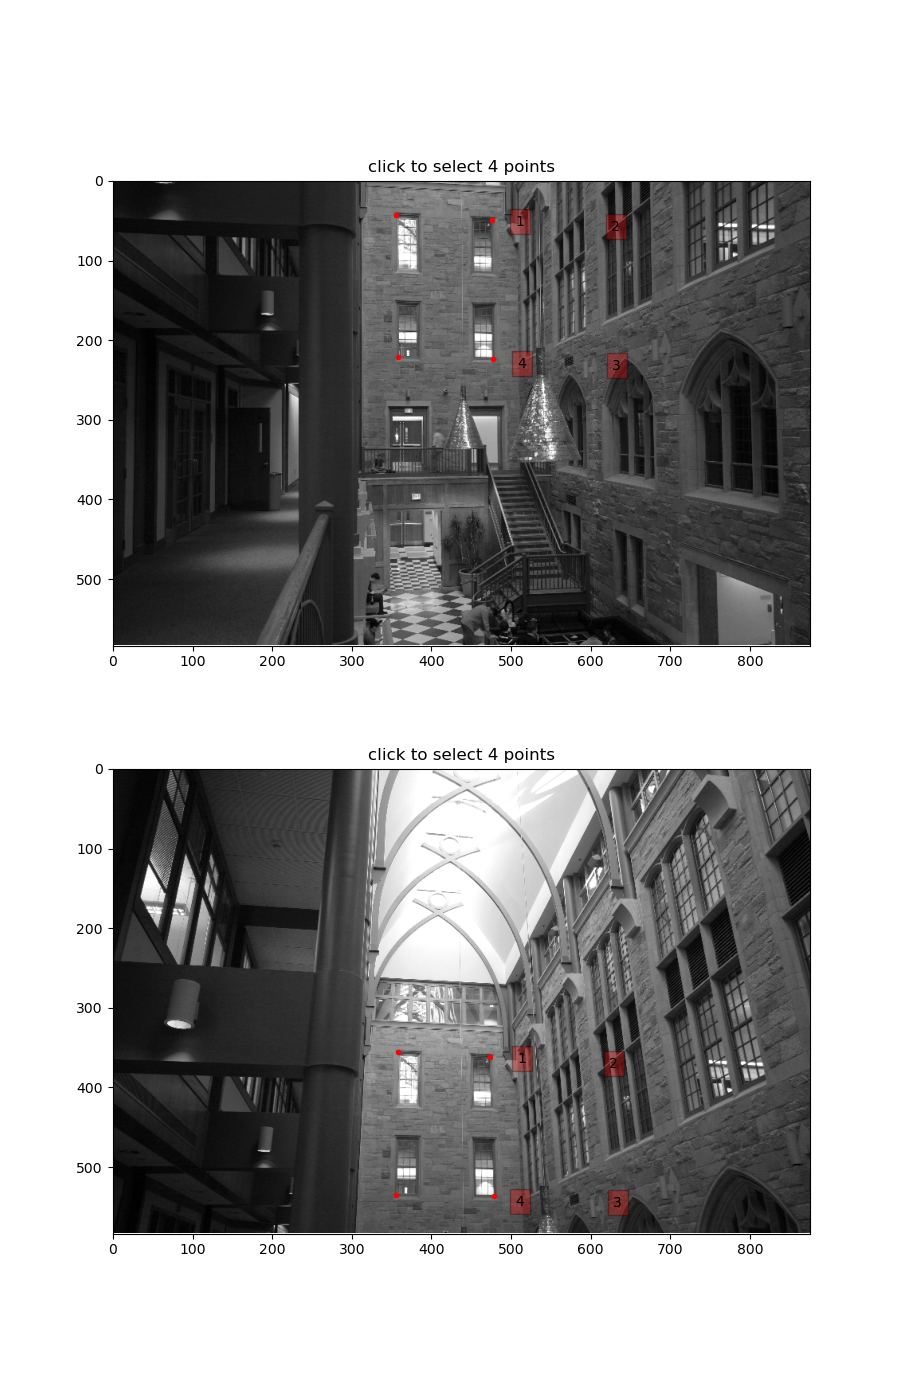

<IPython.core.display.Javascript object>


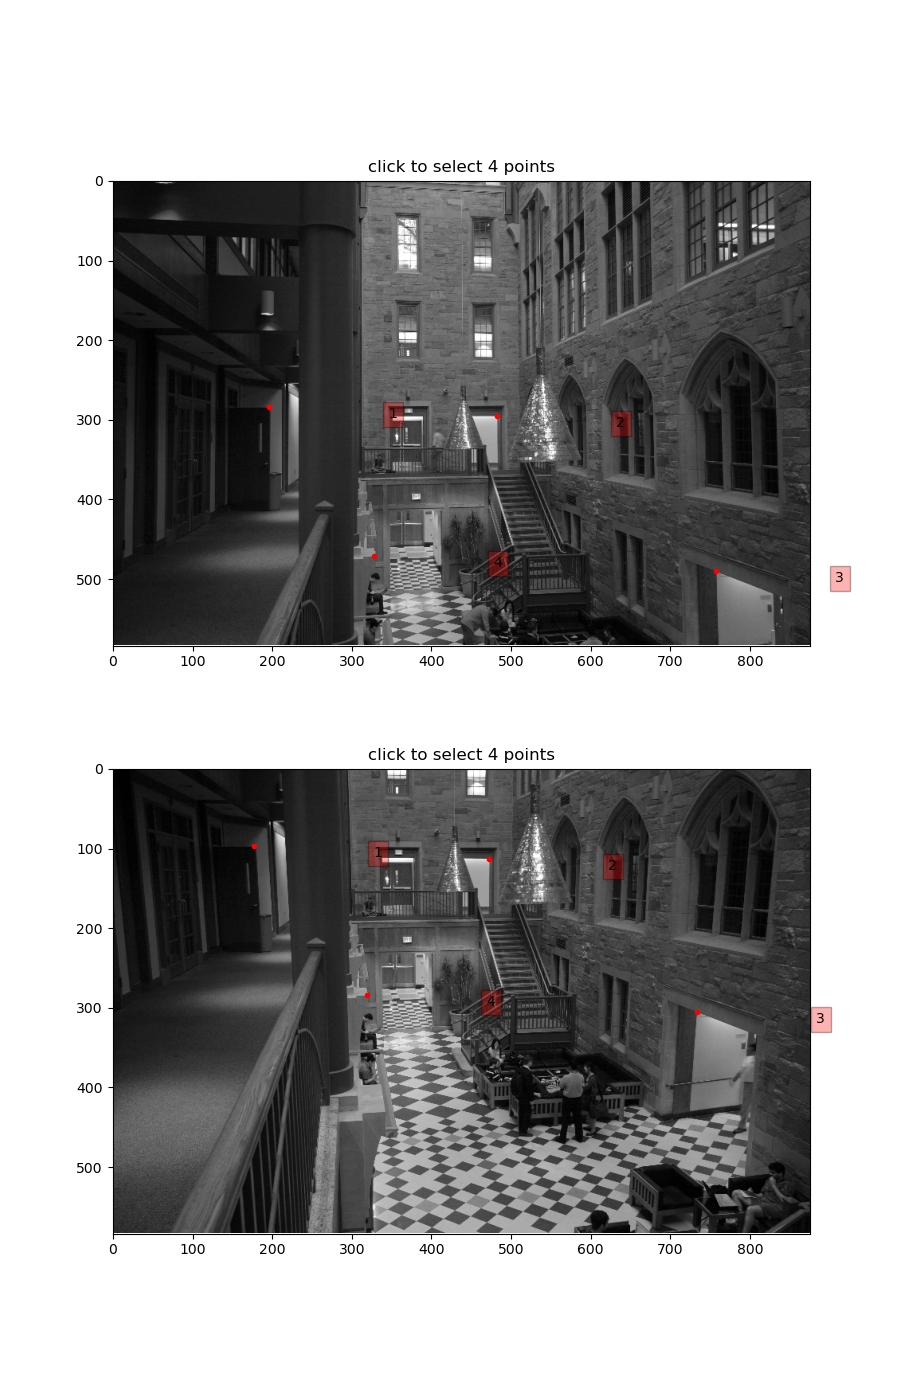

In [11]:
imnames = ('atrium/IMG_1347.JPG','atrium/IMG_1348.JPG','atrium/IMG_1349.JPG')
baseim = 0   #index of the central base image that we will align everything to

#make the default figure size larger to make clicking points easier
#feel free to adjust this to suit your monitor / display size
plt.rcParams['figure.figsize'] = [9, 14]

#call your function to get user clicks
imgs,pointmatches = get_correspondences(imnames,baseim)

#reduce the figure size a bit for visualizations later in the notebook
plt.rcParams['figure.figsize'] = [9, 9]

# after executing this cell, we need to stop and click before running to the next cell

In [12]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))

In [13]:
imgs_warped = warp_images(imgs,baseim,srcpts,basepts)

The output image size would be 1087x1252


In [14]:
mosaic = blend_images(imgs_warped)

<IPython.core.display.Javascript object>


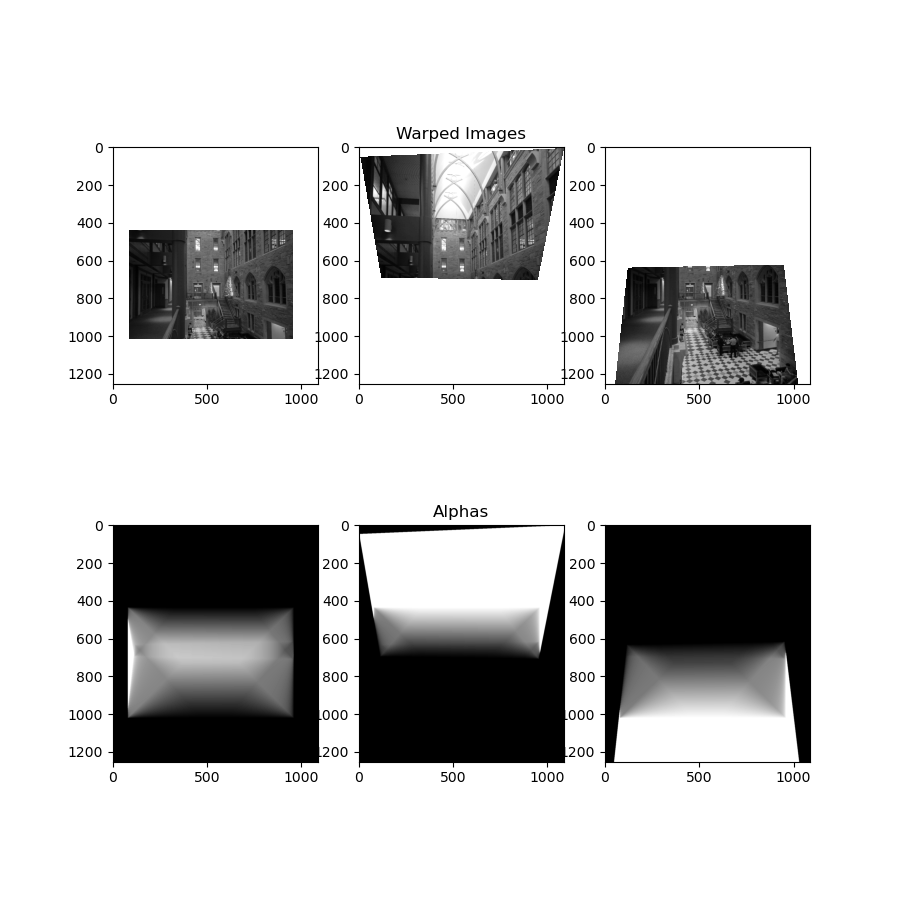

In [15]:
# add code here to display imgs_warped, alphas and the final mosaic in the notebook
fig, ax = plt.subplots(2, 3)
ax[0, 0].imshow(imgs_warped[0], cmap = plt.cm.gray)
ax[0, 1].imshow(imgs_warped[1], cmap = plt.cm.gray)
ax[0, 2].imshow(imgs_warped[2], cmap = plt.cm.gray)
ax[1, 0].imshow(mosaic[1][0], cmap = plt.cm.gray)
ax[1, 1].imshow(mosaic[1][1], cmap = plt.cm.gray)
ax[1, 2].imshow(mosaic[1][2], cmap = plt.cm.gray)
ax[0, 1].set_title("Warped Images")
ax[1, 1].set_title("Alphas")
plt.show()

<IPython.core.display.Javascript object>


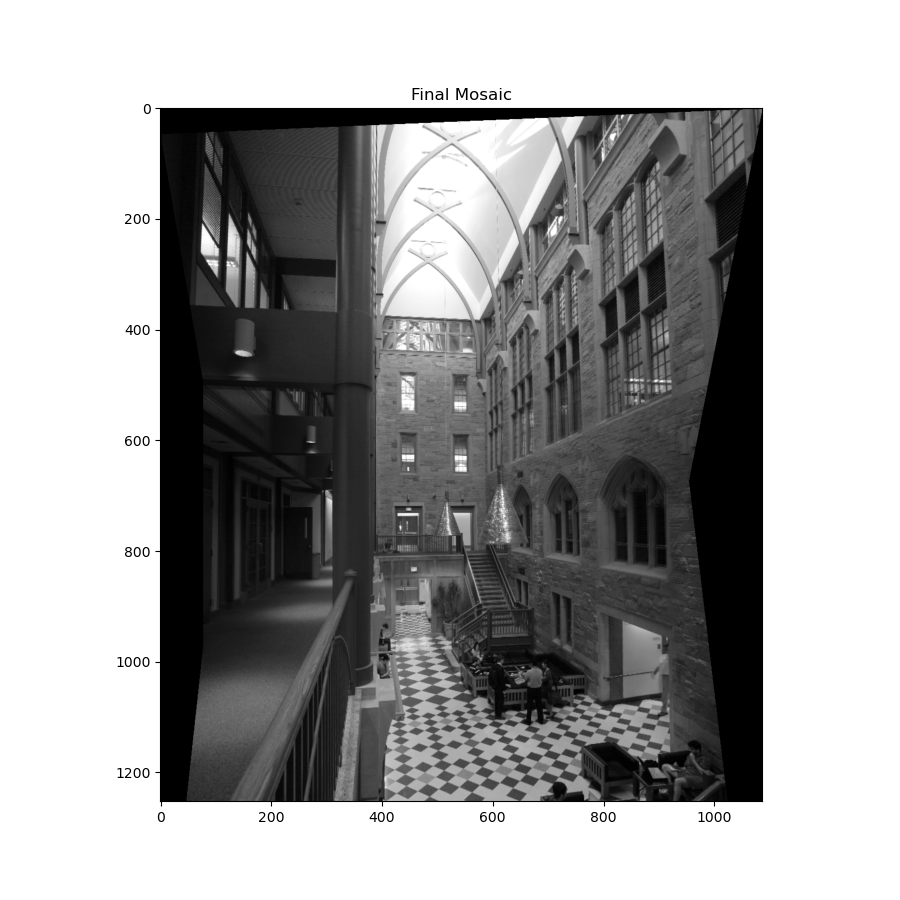

In [16]:
plt.imshow(mosaic[0],cmap=plt.cm.gray)
plt.title("Final Mosaic")
plt.show()

# Result 2

loading... window/IMG_1341.JPG
loading... window/IMG_1342.JPG
loading... window/IMG_1343.JPG
loading... window/IMG_1344.JPG
loading... window/IMG_1345.JPG


<IPython.core.display.Javascript object>


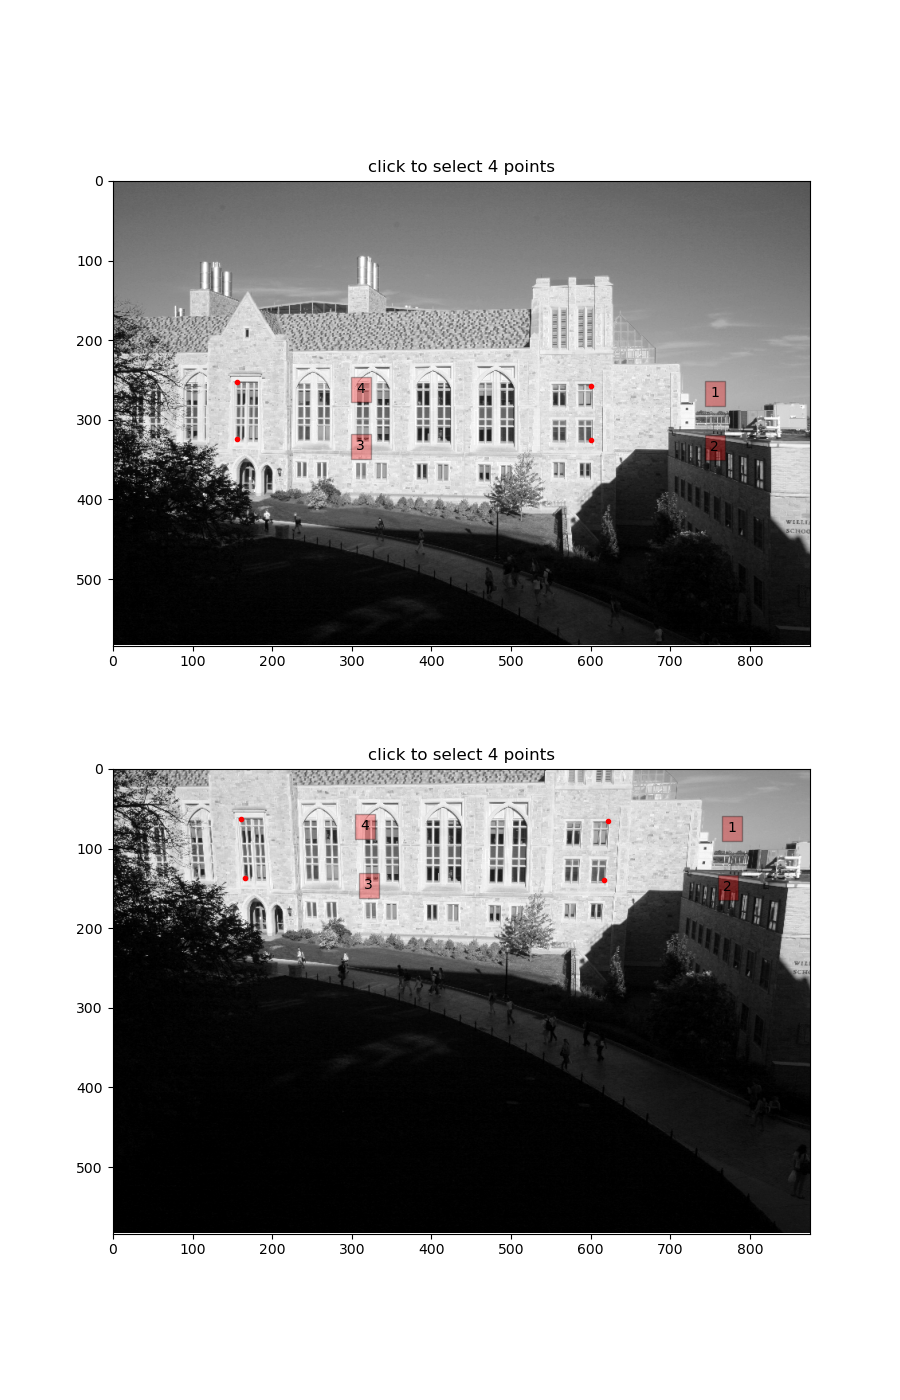

<IPython.core.display.Javascript object>


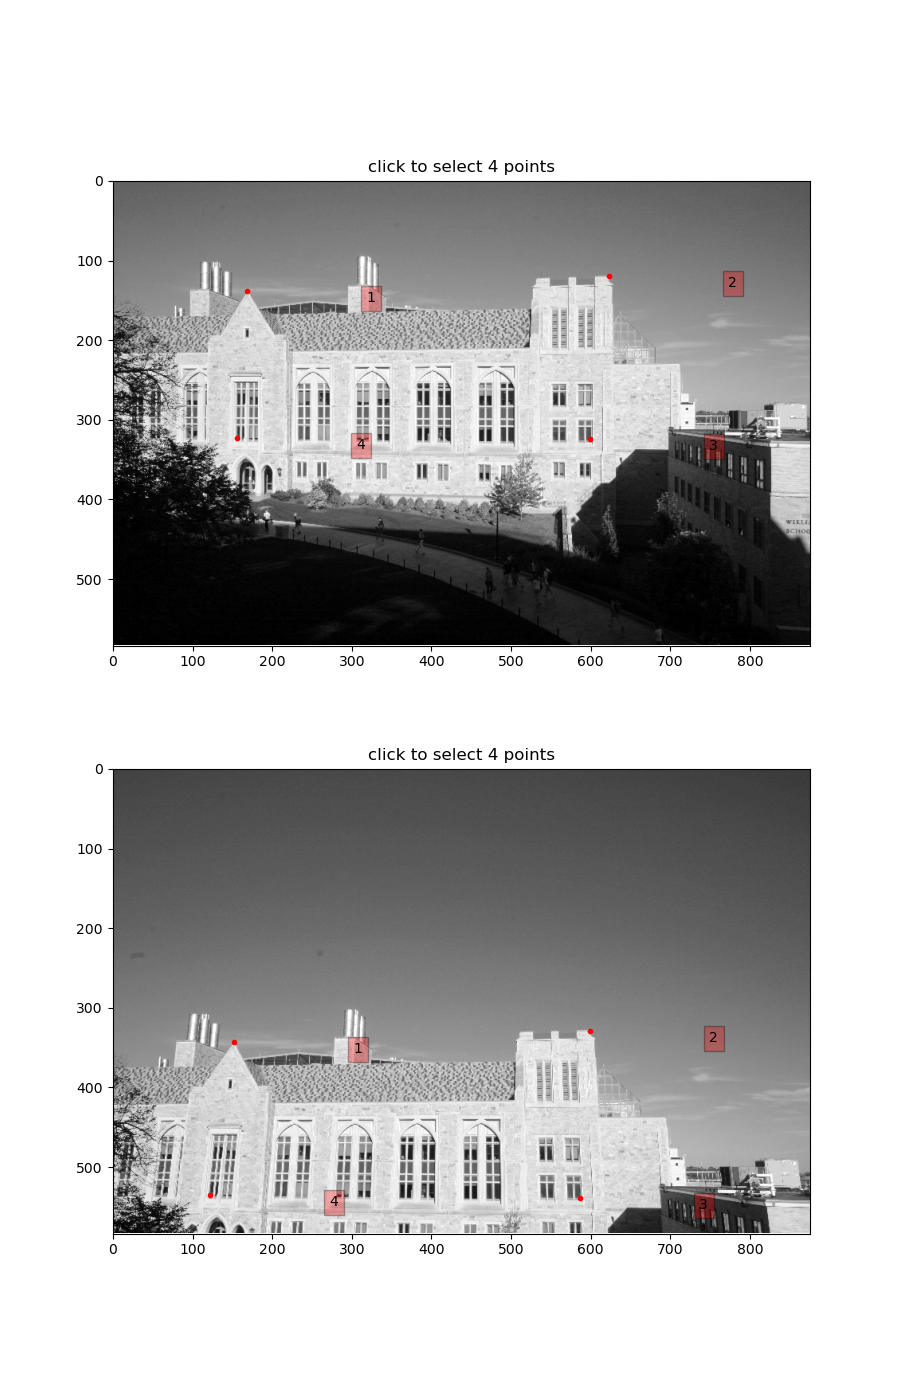

<IPython.core.display.Javascript object>


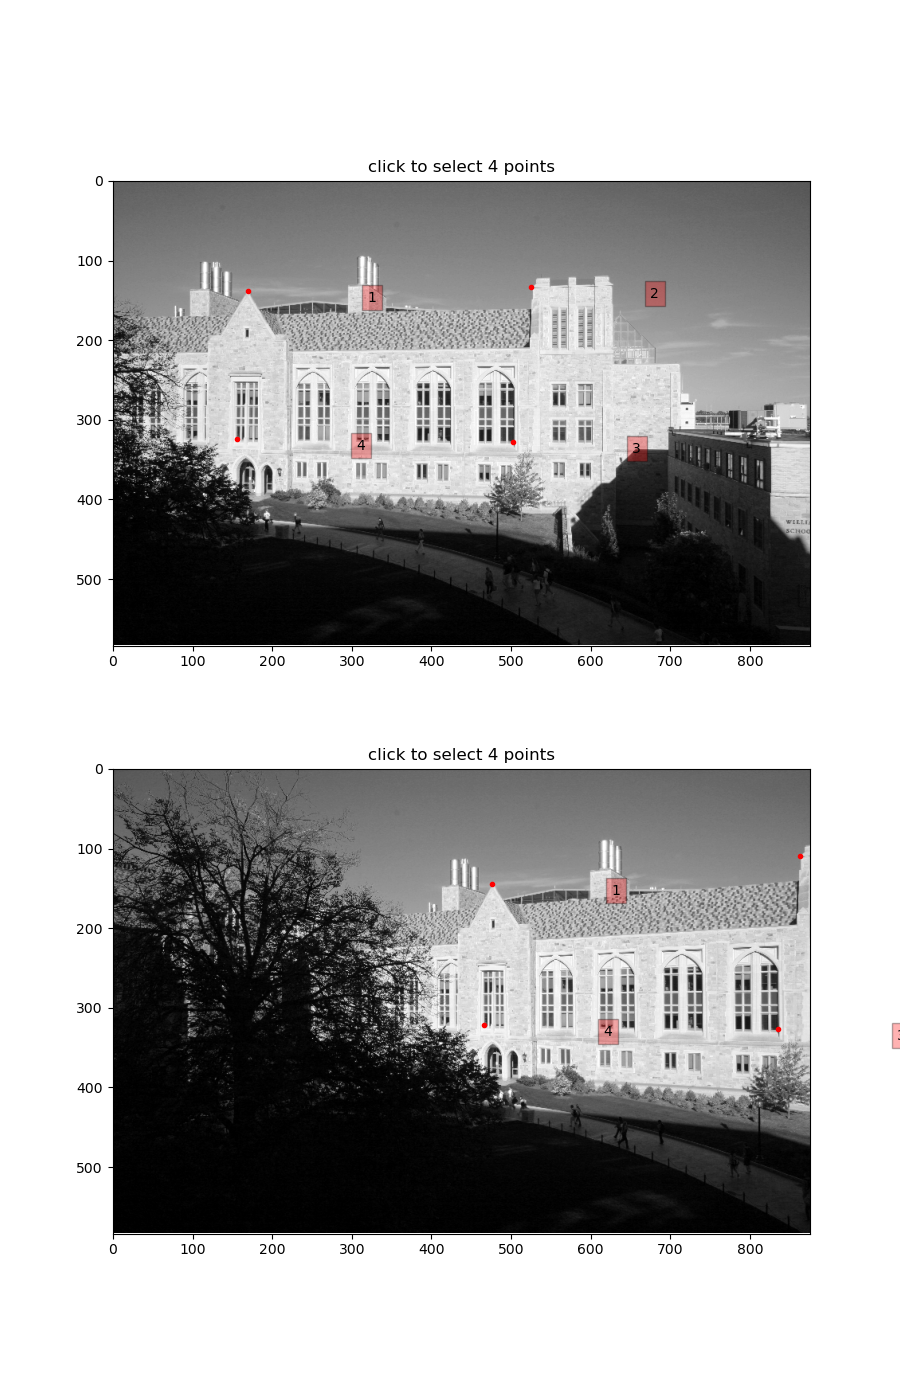

<IPython.core.display.Javascript object>


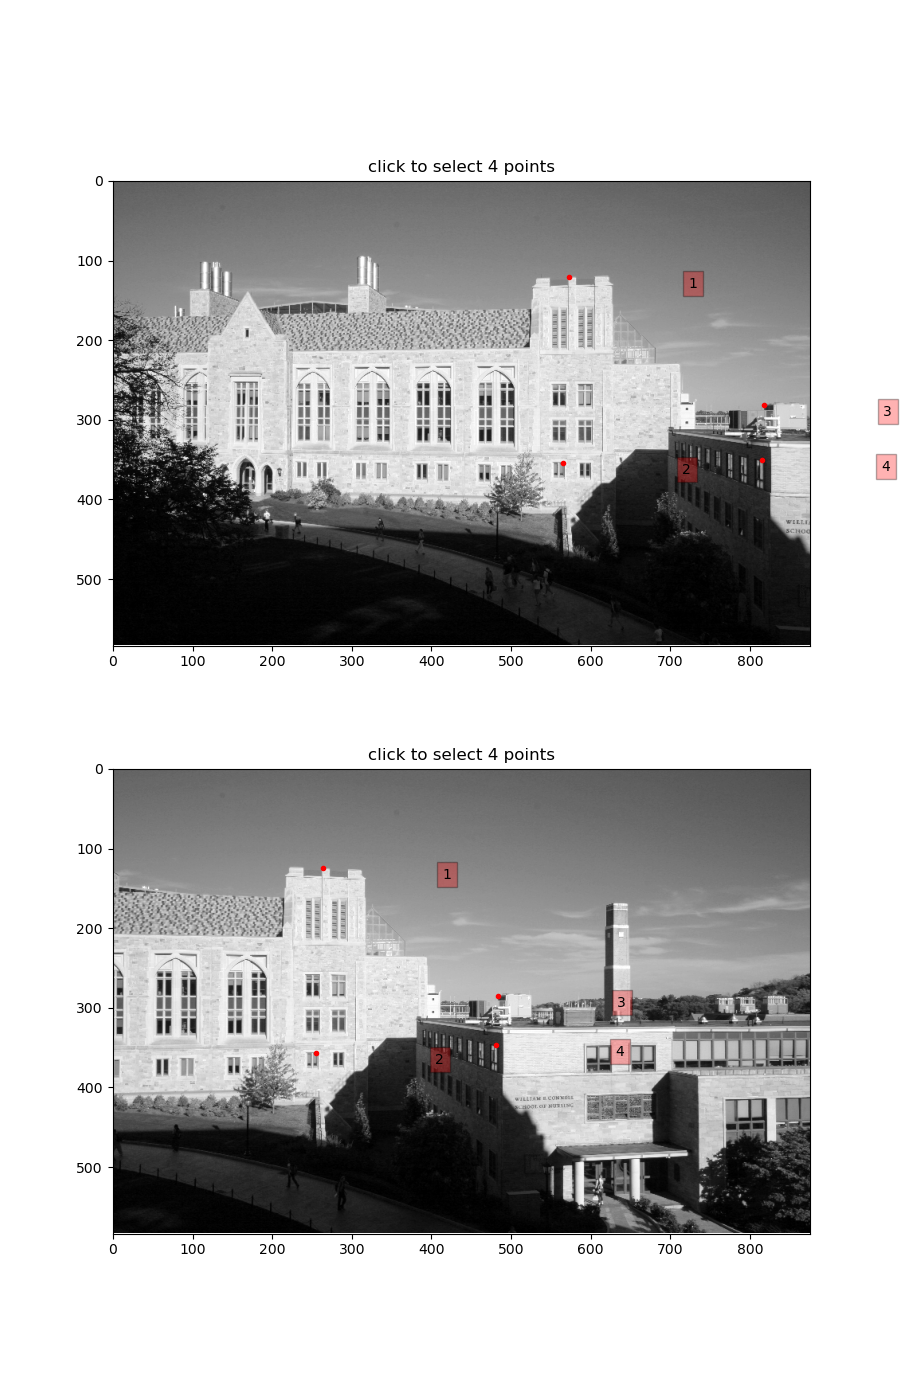

In [17]:
imnames = ('window/IMG_1341.JPG','window/IMG_1342.JPG','window/IMG_1343.JPG','window/IMG_1344.JPG','window/IMG_1345.JPG')
baseim = 0   #index of the central base image that we will align everything to

# make the default figure size larger to make clicking points easier
# feel free to adjust this to suit your monitor / display size
plt.rcParams['figure.figsize'] = [9, 14]

# call function to get user clicks
imgs,pointmatches = get_correspondences(imnames,baseim)

# reduce the figure size a bit for visualizations later in the notebook
plt.rcParams['figure.figsize'] = [9, 9]

# after executing this cell, we need to stop and click before running to the next cell

In [18]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))

In [19]:
imgs_warped = warp_images(imgs,baseim,srcpts,basepts)

The output image size would be 1934x1121


In [20]:
mosaic = blend_images(imgs_warped)

<IPython.core.display.Javascript object>


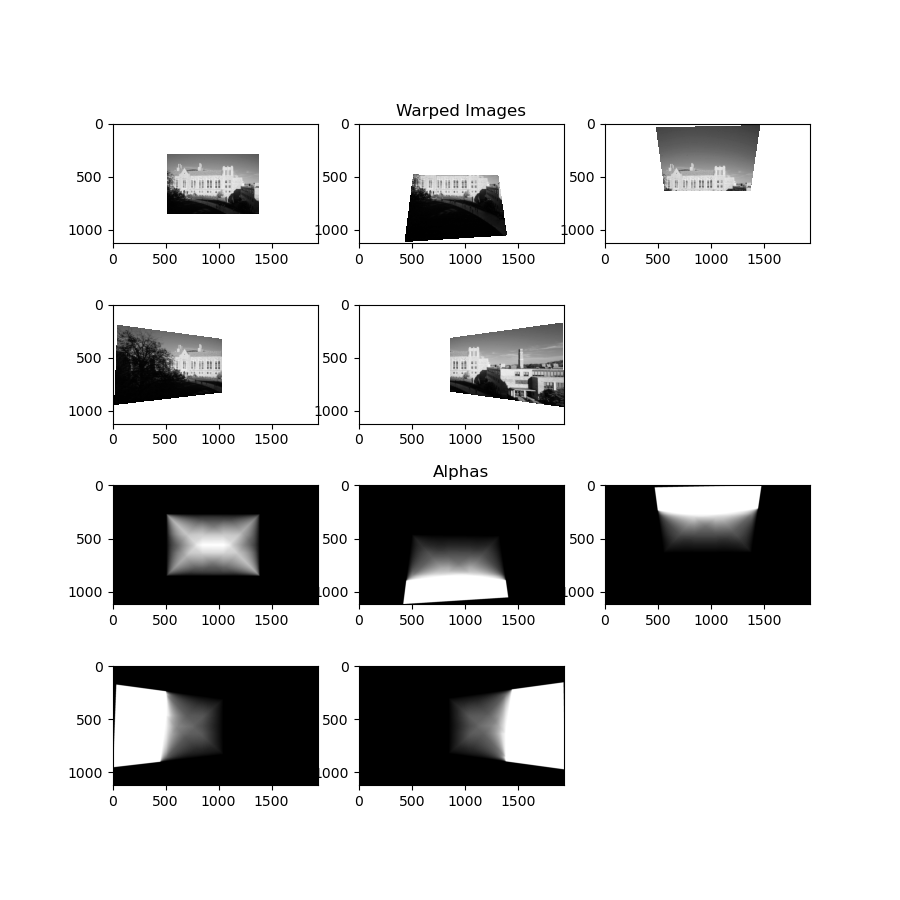

In [21]:
fig, ax = plt.subplots(4, 3)
ax[0, 0].imshow(imgs_warped[0], cmap = plt.cm.gray)
ax[0, 1].imshow(imgs_warped[1], cmap = plt.cm.gray)
ax[0, 2].imshow(imgs_warped[2], cmap = plt.cm.gray)
ax[1, 0].imshow(imgs_warped[3], cmap = plt.cm.gray)
ax[1, 1].imshow(imgs_warped[4], cmap = plt.cm.gray)
ax[1, 2].remove()

ax[2, 0].imshow(mosaic[1][0], cmap = plt.cm.gray)
ax[2, 1].imshow(mosaic[1][1], cmap = plt.cm.gray)
ax[2, 2].imshow(mosaic[1][2], cmap = plt.cm.gray)
ax[3, 0].imshow(mosaic[1][3], cmap = plt.cm.gray)
ax[3, 1].imshow(mosaic[1][4], cmap = plt.cm.gray)
ax[3, 2].remove()

ax[0, 1].set_title("Warped Images")
ax[2, 1].set_title("Alphas")
plt.show()

<IPython.core.display.Javascript object>


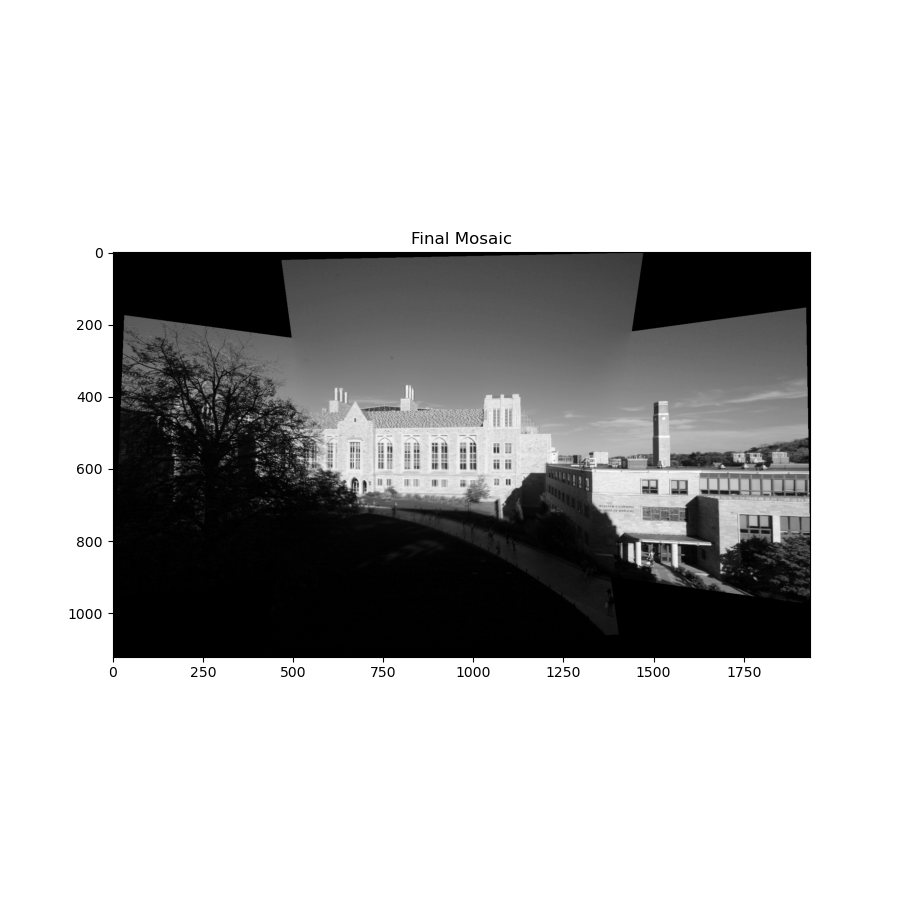

In [22]:
plt.imshow(mosaic[0],cmap=plt.cm.gray)
plt.title("Final Mosaic")
plt.show()

# Result 3

loading... mypic/IMG_7537.JPG
loading... mypic/IMG_7538.JPG
loading... mypic/IMG_7539.JPG


<IPython.core.display.Javascript object>


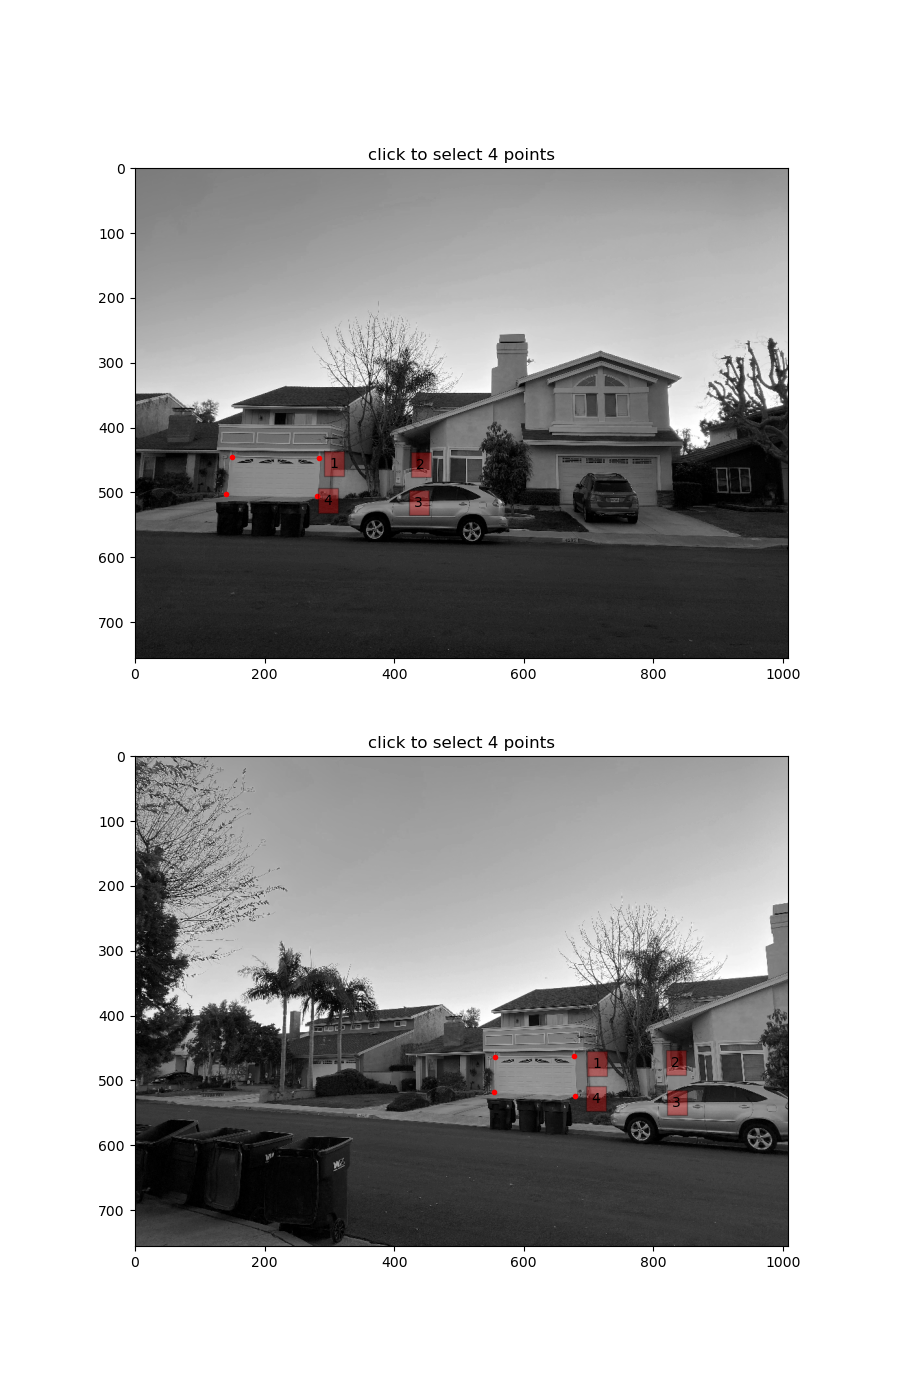

<IPython.core.display.Javascript object>


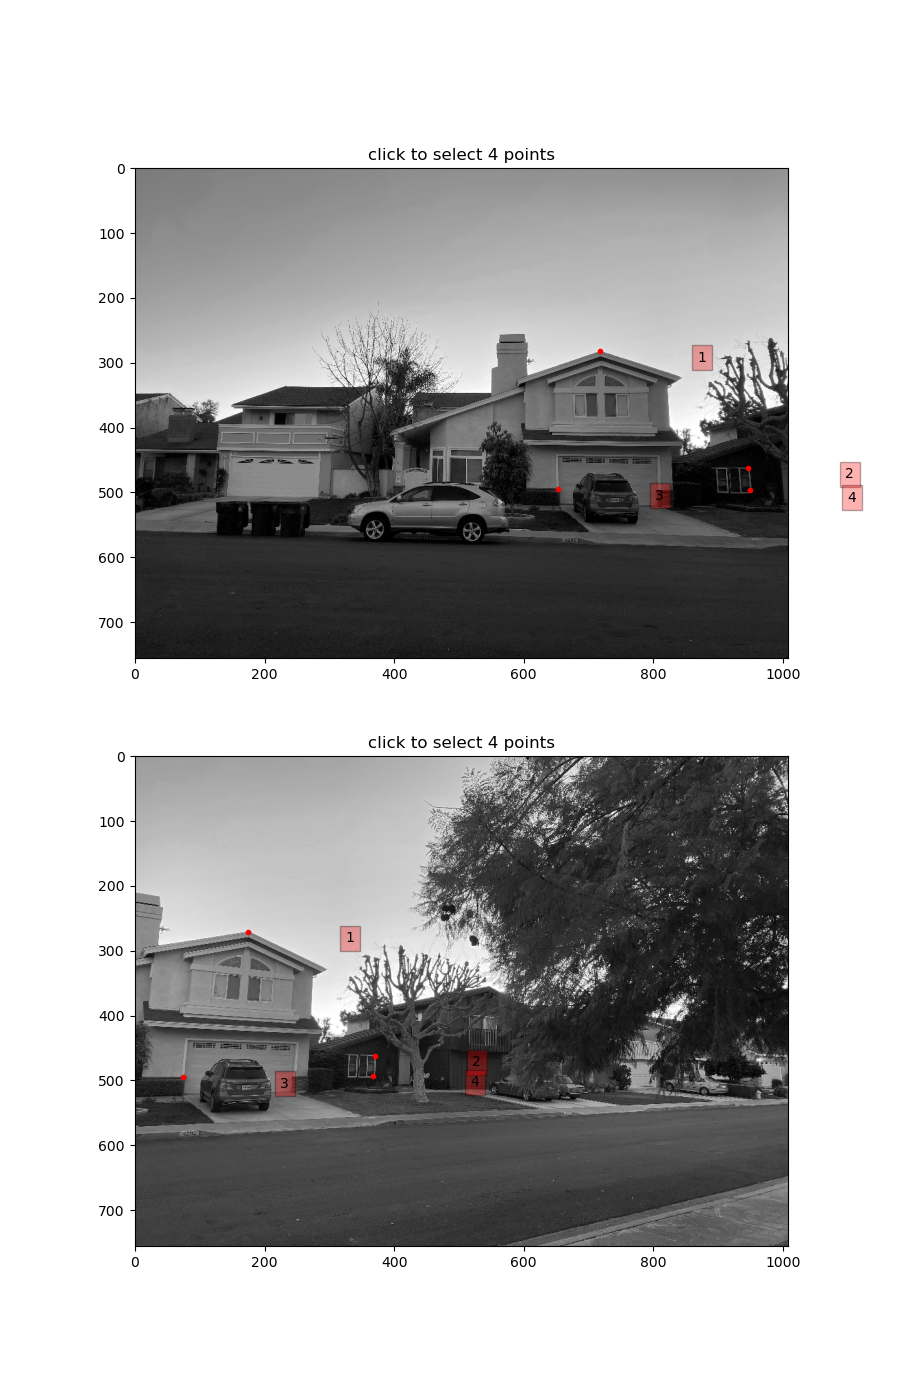

In [23]:
imnames = ('street/IMG_7537.JPG','street/IMG_7538.JPG', 'street/IMG_7539.JPG')
baseim = 0   # index of the central base image that we will align everything to

# make the default figure size larger to make clicking points easier
# feel free to adjust this to suit your monitor / display size
plt.rcParams['figure.figsize'] = [9, 14]

# call function to get user clicks
imgs,pointmatches = get_correspondences(imnames,baseim)

# reduce the figure size a bit for visualizations later in the notebook
plt.rcParams['figure.figsize'] = [9, 9]

# after executing this cell, we need to stop and click before running to the next cell

In [24]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))

In [25]:
imgs_warped = warp_images(imgs,baseim,srcpts,basepts)

The output image size would be 4406x1499


In [26]:
mosaic = blend_images(imgs_warped)

<IPython.core.display.Javascript object>


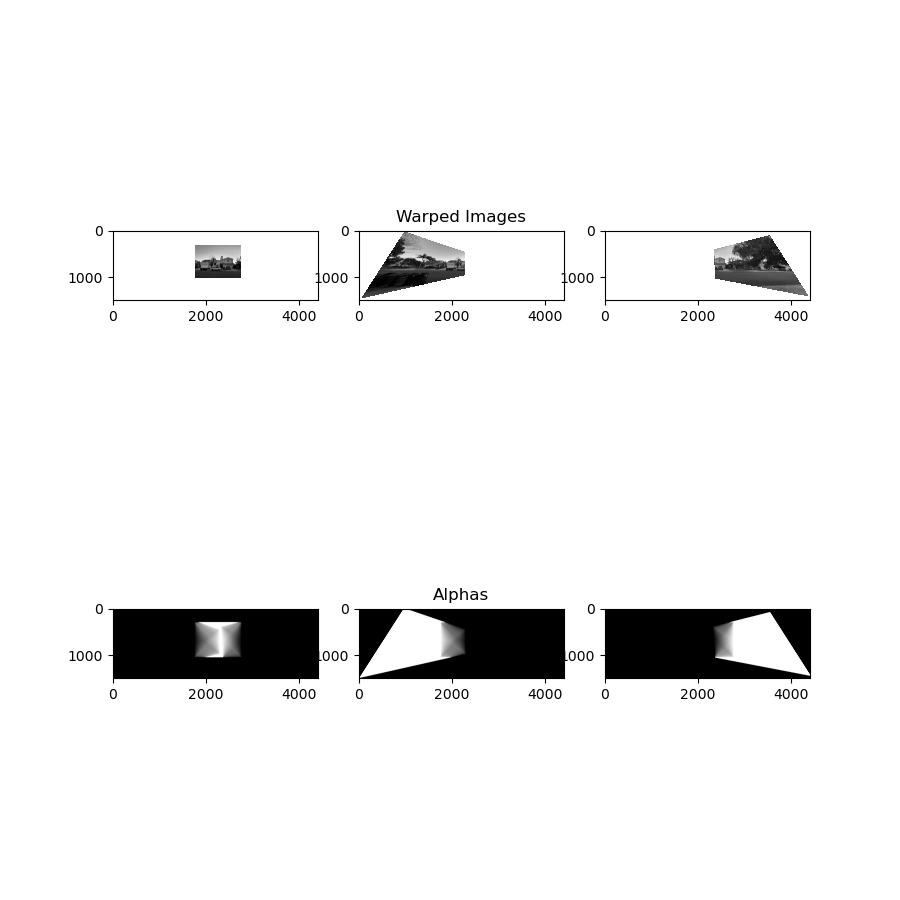

In [27]:
fig, ax = plt.subplots(2, 3)
ax[0, 0].imshow(imgs_warped[0], cmap = plt.cm.gray)
ax[0, 1].imshow(imgs_warped[1], cmap = plt.cm.gray)
ax[0, 2].imshow(imgs_warped[2], cmap = plt.cm.gray)
ax[1, 0].imshow(mosaic[1][0], cmap = plt.cm.gray)
ax[1, 1].imshow(mosaic[1][1], cmap = plt.cm.gray)
ax[1, 2].imshow(mosaic[1][2], cmap = plt.cm.gray)
ax[0, 1].set_title("Warped Images")
ax[1, 1].set_title("Alphas")
plt.show()

<IPython.core.display.Javascript object>


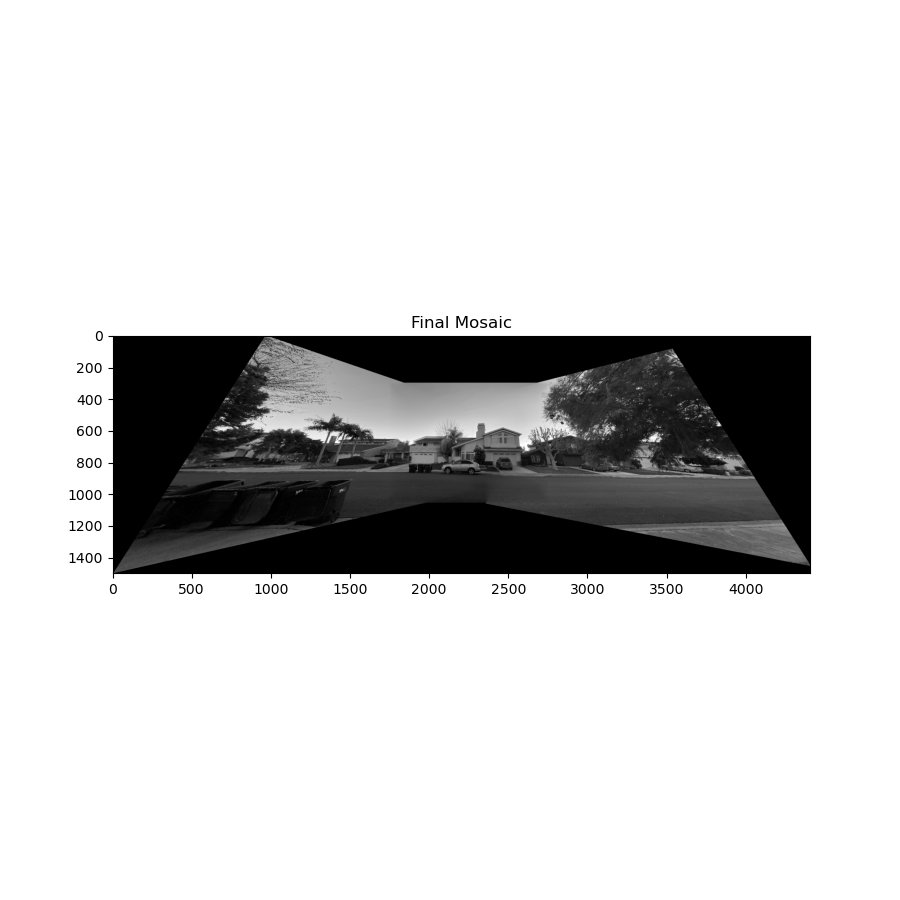

In [28]:
plt.imshow(mosaic[0],cmap=plt.cm.gray)
plt.title("Final Mosaic")
plt.show()